In [22]:
import sys
import logging

import numpy as np
import scipy as sp
import sklearn
import math

from numpy import array

%load_ext autoreload
%autoreload 2


import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

from fox_toolbox.utils import xml_parser, rates, volatility
from mc import mc
from hw import calibration as hw_calib

from hw import Henrard
from hw import Jamshidian
from hw import hw_helper

def get_variable_value(irsmout, var_name):
    return float([node for node in irsmout.findall('.//Variable') if node.find('VariableDescription').text.split()[0] == f'{var_name}' ][0].find('VariableValue').text)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
OUTPUT_5SWO, INPUT_5SWO = xml_parser.get_files('hw bond 5swo xml', 'hw_bond')

main_curve, sprds = xml_parser.get_rate_curves(INPUT_5SWO)
dsc_curve = main_curve

try:
    estim_curve = sprds[0]
except TypeError:
    estim_curve = main_curve
    
T = 5. # irsmform Pay(0, 1., ***T***, 0, 1000)
U = T  # T-measure numeraire maturity
t = 4. # irsmform T formula fixing

spotstep = 1000
timestep = 100

x0 = 0.

PieceWise = 'PieceWise'

np.random.seed(21)

_, irsmout = xml_parser.get_xml(OUTPUT_5SWO)

ref_mr, (hw_buckets, hw_sigma) = xml_parser.get_hw_params(irsmout)
a = ref_mr

ref_sigmas = rates.Curve(hw_buckets, hw_sigma, 'PieceWise')
# ref_sigmas = rates.Curve(array([ 0.  , 1. , 30.  ]), array([0.1, 0.1, 0.1]), 'PieceWise', '')
sigma = ref_sigmas
print(ref_sigmas)

hw = mc.HullWhiteProcess( mr = ref_mr, sigma = ref_sigmas, x0 = x0)
df = hw.generate_paths(until=T, timestep=timestep, spotstep=spotstep, measure = 'RN')



c = 0
for x in df.loc[t]:
    c+= hw.fwd_bond(t, T, dsc_curve, x)
    
my_bond = c/spotstep

my_disc_bond = my_bond * dsc_curve.get_dsc(t)

ref_price = get_variable_value(irsmout, var_name='HWFwdBond')

print('\n my monte carlo discounted bond price:', 1e2 * my_disc_bond)
print('\n irsmout bond price:', 1e2 * ref_price)

(ref_price - my_disc_bond) / my_disc_bond

Curve
--------------------------------------------------------------------------------
Name: ''
Pillars: array([ 0.        ,  0.99726027, 30.99726027])
Zero-coupons: array([0.11615363, 0.11615363, 0.11615363])
Interpolation: 'PieceWise'

 my monte carlo discounted bond price: 77.01635314481895

 irsmout bond price: 99.10763859623


0.28683889264233714

In [75]:
df.loc[t].describe()

count    1000.000000
mean        0.002725
std         0.217589
min        -0.698848
25%        -0.130139
50%         0.004041
75%         0.133668
max         0.660941
Name: 4.0, dtype: float64

In [76]:
m = df.loc[t].mean()
s = df.loc[t].std()
c = df.loc[t].count()

In [77]:
(m - 1.96*s/math.sqrt(c)),\
(m + 1.96*s/math.sqrt(c))

(-0.010761630209967517, 0.016211012208534208)

In [78]:
ee = np.exp(-hw_helper._B(t, T, a) * df.loc[t] + 0.5 * (hw_helper._V(0, t, t, a, sigma) - hw_helper._V(0, t, T, a, sigma)));

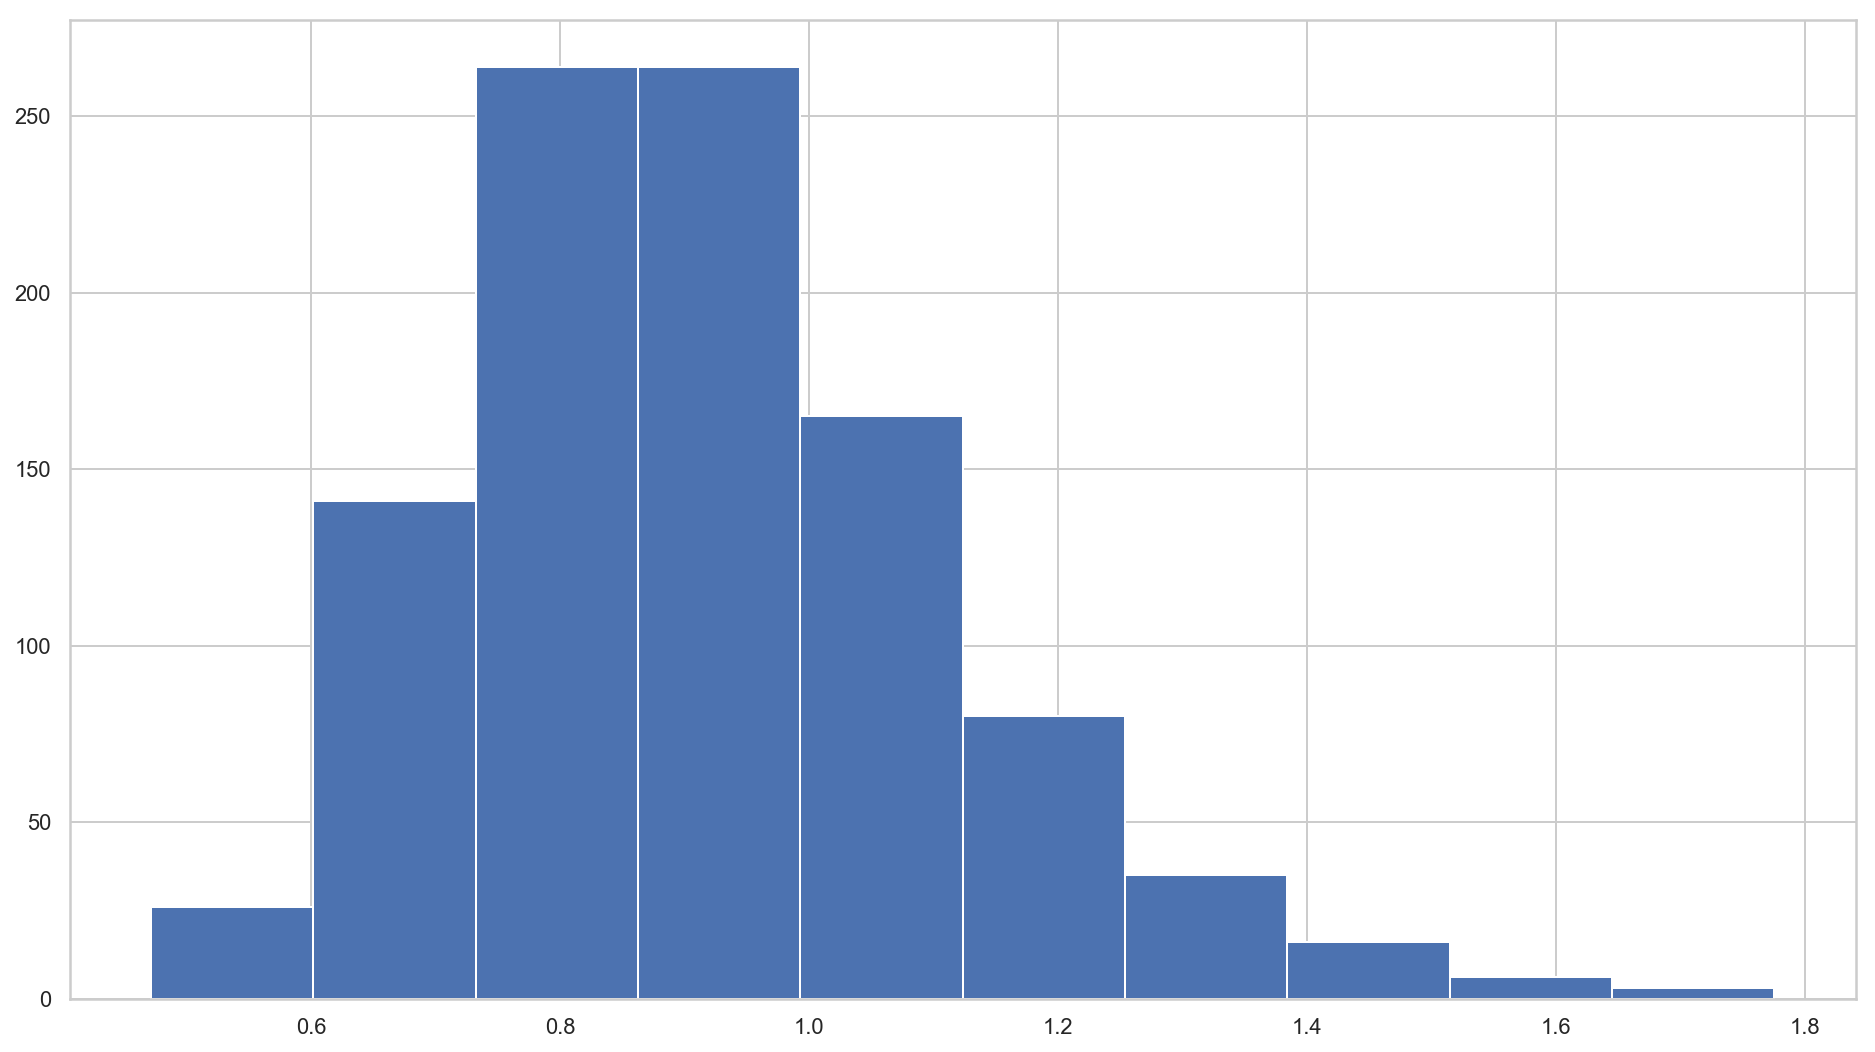

In [80]:
ee.hist()

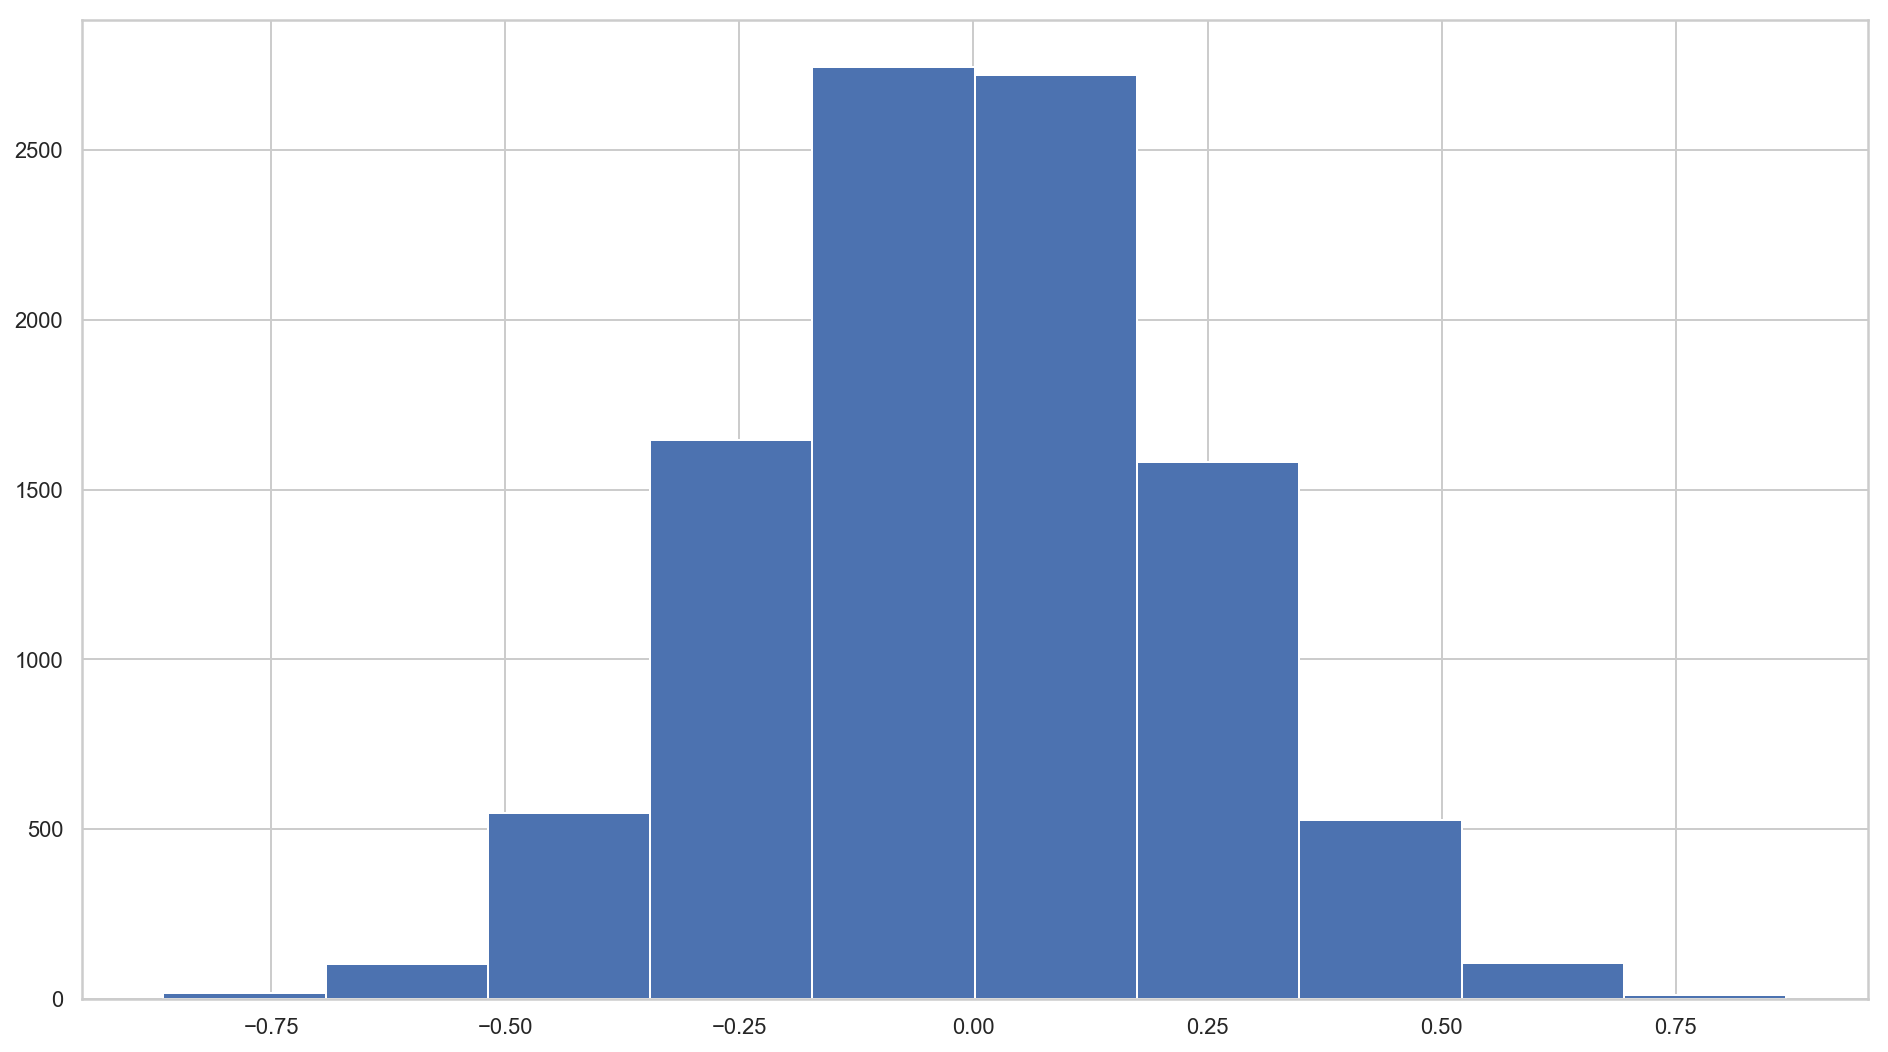

In [53]:
df.loc[5].hist()

In [16]:
hw_helper.hw_integrate(sigma, hw_helper._mT_integral, T, U, a)

0.13322060911048356

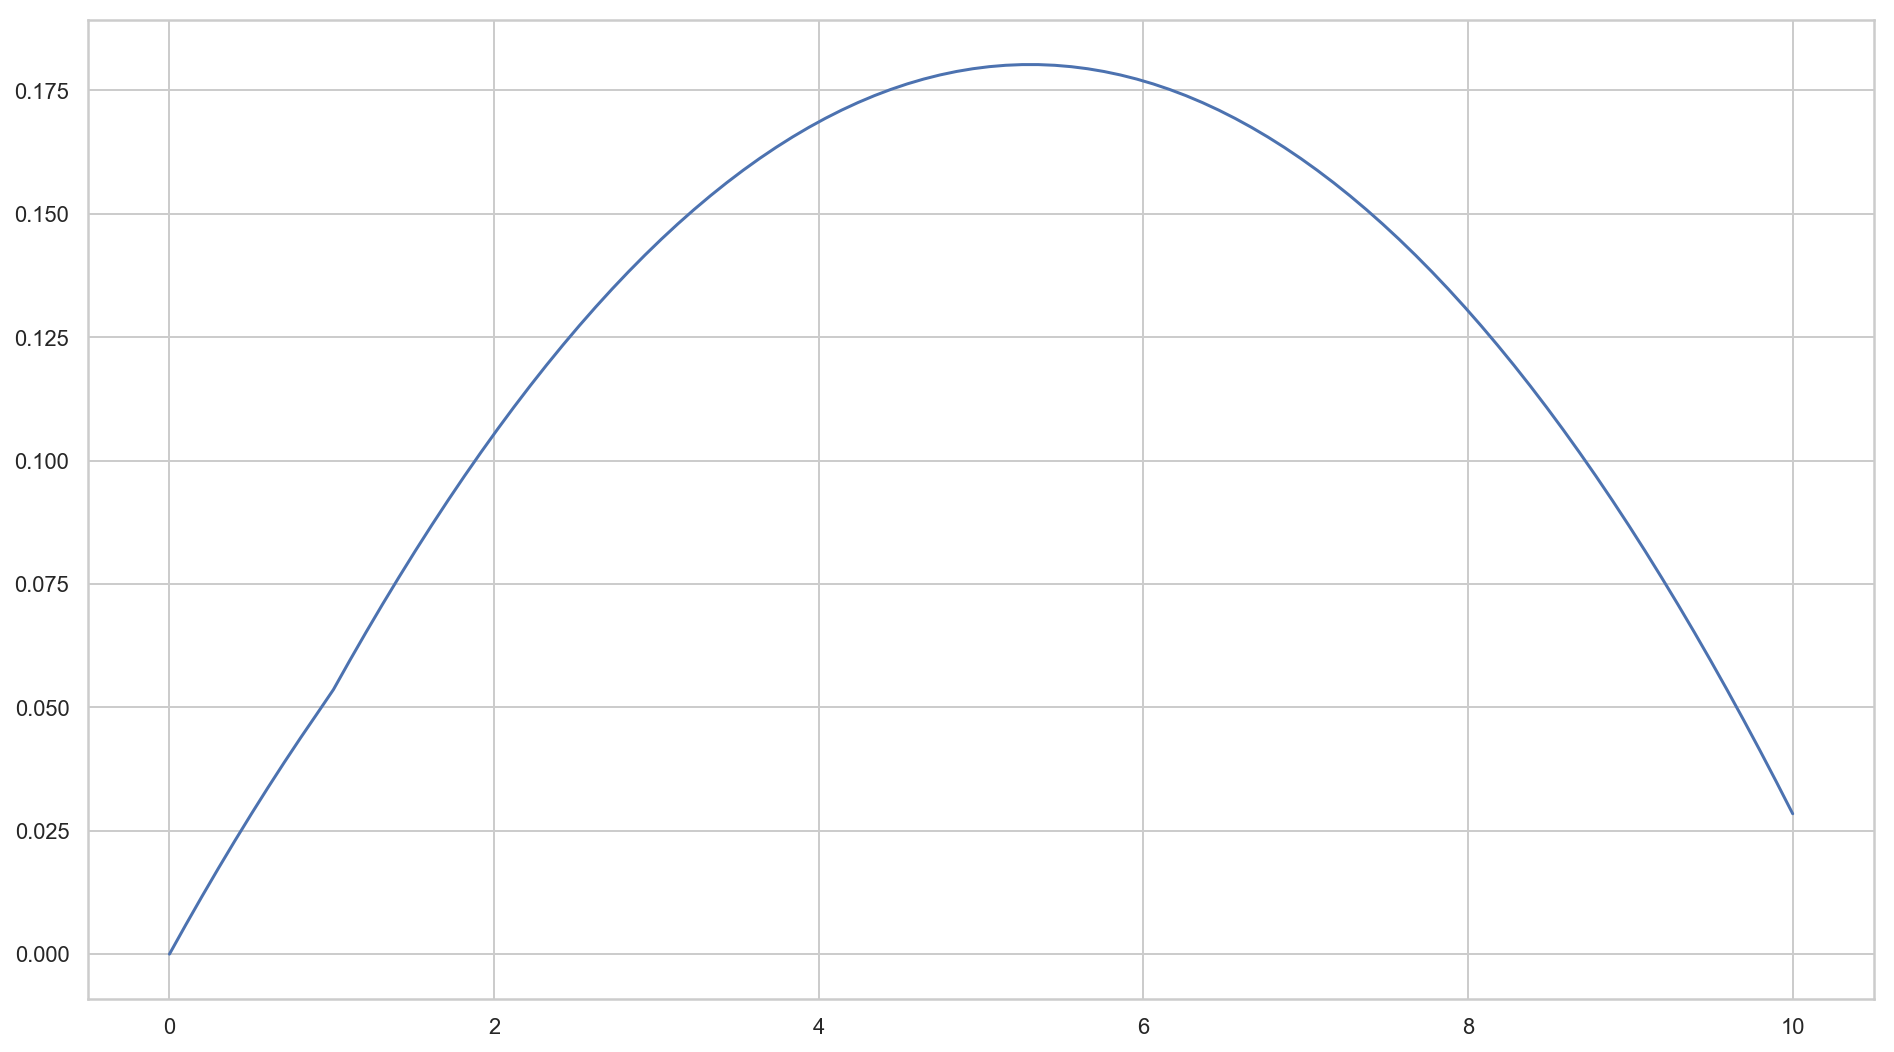

In [39]:
xx = np.linspace(0, 10, 100)

plt.plot(xx, [hw_helper.hw_integrate(sigma, hw_helper._mT_integral, TT, U, a) for TT in xx])

In [4]:
ref_sigmas

Curve(array([ 0.,  1., 30.]), array([0.1, 0.1, 0.1]), PieceWise, '')

In [5]:
hw_helper.hw_integrate(sigma, hw_helper._v, T, T, a)

2.3297279071636545

In [6]:
from numpy import array
ts = array( [t_ for t_ in sigma.buckets[  :-1 ] if t_ < T])
Ts = array( [T_ for T_ in sigma.buckets[ 1:   ] if T_ < T] + [T] )

In [8]:
hw_helper._V(t, T, T, a, sigma)

2.3297279071636545